# Loan Approval Prediction
# Logistic Regression

In [1]:
import os
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, f1_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt



Loading Configuration

In [2]:
with open("config.yaml") as f:
    cfg = yaml.safe_load(f)

DATA_DIR = Path(cfg["data_dir"]).expanduser()
FILENAME = cfg["filename"]
RANDOM_SEED = cfg["random_seed"]

Data preparation

In [3]:
df = pd.read_csv(os.path.join(DATA_DIR, FILENAME))

In [4]:
# split columns into numerical and categorical
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# remove target column from numerical columns
numerical_cols.remove('loan_status')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [5]:
# convert all categorical values to lowercase
for col in categorical_cols:
    df[col] = df[col].str.lower()

In [ ]:
# fill missing values with median for numerical columns
df['person_emp_length'] = df['person_emp_length'].fillna((df['person_emp_length'].median()))
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())
# split columns into numerical and categorical
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# remove target column from numerical columns
numerical_cols.remove('loan_status')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [8]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,rent,123.0,personal,d,35000,16.02,1,0.59,y,3
1,21,9600,own,5.0,education,b,1000,11.14,0,0.10,n,2
2,25,9600,mortgage,1.0,medical,c,5500,12.87,1,0.57,n,3
3,23,65500,rent,4.0,medical,c,35000,15.23,1,0.53,n,2
4,24,54400,rent,8.0,medical,c,35000,14.27,1,0.55,y,4


Split data to train, val, test (60, 20, 20)

In [9]:
# Split
X_train_full, X_test = train_test_split(df, test_size=0.2, shuffle=True, 
                                        stratify=df['loan_status'], random_state=RANDOM_SEED)
X_train, X_val = train_test_split(X_train_full, test_size=0.25, shuffle=True,
                                  stratify=X_train_full['loan_status'], random_state=RANDOM_SEED) 

# reset index
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# separate target
y_train = X_train['loan_status'].values
y_val = X_val['loan_status'].values
y_test = X_test['loan_status'].values

X_train = X_train.drop(columns=['loan_status'])
X_val = X_val.drop(columns=['loan_status'])
X_test = X_test.drop(columns=['loan_status'])


In [10]:
# check data lengths
print(len(X_train), len(X_val), len(X_test))


19548 6516 6517


In [11]:
# reusable preprocessor and model builders

def build_preprocessor(categorical_cols, numerical_cols, use_log1p=False, use_scaler=False, handle_unknown='ignore'):

    transformers = [
        ('cat', OneHotEncoder(handle_unknown=handle_unknown), categorical_cols)
    ]

    # numeric
    if use_log1p or use_scaler:
        steps = []
        if use_log1p:
            steps.append(('log1p', FunctionTransformer(np.log1p)))
        if use_scaler:
            steps.append(('scaler', StandardScaler()))
        numeric_pipeline = Pipeline(steps)
        transformers.append(('num', numeric_pipeline, numerical_cols))
    else:
        transformers.append(('num', 'passthrough', numerical_cols))

    return ColumnTransformer(transformers)



def build_lr_pipeline(preprocessor, class_weight=None, random_state=RANDOM_SEED, 
                      solver='liblinear', C=1.0):
    """Construct a LogisticRegression pipeline given a preprocessor."""
    return Pipeline([
        ('preprocessor', preprocessor),
        ('clf', LogisticRegression(solver=solver, class_weight=class_weight, C= C,
                                   random_state=random_state))
    ])



In [12]:
def evaluate_model(model, X, y_true, threshold=0.5, experiment="", printOut=True, model_name=""):
    y_pred = model.predict_proba(X)[:, 1]
    y_pred_th = (y_pred >= threshold).astype(int)

    accuracy = accuracy_score(y_true, y_pred_th)
    conf_matrix = confusion_matrix(y_true, y_pred_th)
    precision = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
    recall = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    f1 = f1_score(y_true, y_pred_th)
    roc_auc = roc_auc_score(y_true  , y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    if printOut:
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        print("ROC AUC:", roc_auc)
        print("Confusion Matrix:\n", conf_matrix)

    result = {
        "model": model_name,
        "experiment": experiment,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "fpr": fpr,
        "tpr": tpr,
        "confusion_matrix": conf_matrix,
        "threshold": threshold
    }

    return result


In [13]:
arr_experiment_results = []

## E1-1 Experiment 1-1
Logistic Regression, Baseline

In [14]:
# Preprocess and model via helpers
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    use_log1p=False,
    use_scaler=False
)

model = build_lr_pipeline(
    preprocessor=preprocessor,
    class_weight=None
)

In [15]:
e11_model = model.fit(X_train, y_train)

r = evaluate_model(e11_model, X_val, y_val, 
                   experiment="E1-1", model_name="Logistic Regression")
arr_experiment_results.append(r)

Accuracy: 0.8086249232658073
Precision: 0.8
Recall: 0.16326530612244897
F1 Score: 0.2711864406779661
ROC AUC: 0.7665479050745202
Confusion Matrix:
 [[5037   58]
 [1189  232]]


In [16]:
# check feature count matches coefficient count, to make sure no mismatch
X_transformed = preprocessor.transform(X_train)
print("Transformed feature count:", X_transformed.shape[1])
print("Coefficient count:", e11_model['clf'].coef_.shape[1])


Transformed feature count: 26
Coefficient count: 26


## E1-2. Experiment 1-2
Logistic Regression, with class_balance

In [17]:
# Preprocess and model via helpers
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    use_log1p=False,
    use_scaler=False
)

model = build_lr_pipeline(
    preprocessor=preprocessor,
    class_weight='balanced'
)

In [18]:
e12_model = model.fit(X_train, y_train)

r = evaluate_model(e12_model, X_val, y_val, 
                   experiment="E1-2", model_name="Logistic Regression")
arr_experiment_results.append(r)

Accuracy: 0.7430939226519337
Precision: 0.4490535642368103
Recall: 0.784658691062632
F1 Score: 0.5712090163934426
ROC AUC: 0.8326299949102174
Confusion Matrix:
 [[3727 1368]
 [ 306 1115]]


In [19]:
# check feature count matches coefficient count, to make sure no mismatch
X_transformed = preprocessor.transform(X_train)
print("Transformed feature count:", X_transformed.shape[1])
print("Coefficient count:", e12_model['clf'].coef_.shape[1])


Transformed feature count: 26
Coefficient count: 26


## E1-3. Experiment 1-3
Logistic Regression, with class_balance and log1p transformation

In [20]:
# Preprocess and model via helpers
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    use_log1p=True,
    use_scaler=False
)

model = build_lr_pipeline(
    preprocessor=preprocessor,
    class_weight='balanced'
)

In [21]:
e13_model = model.fit(X_train, y_train)

r = evaluate_model(e13_model, X_val, y_val, 
                   experiment="E1-3", model_name="Logistic Regression")
arr_experiment_results.append(r)

Accuracy: 0.8126151012891344
Precision: 0.548828125
Recall: 0.7909922589725545
F1 Score: 0.6480253675410781
ROC AUC: 0.8752315436681931
Confusion Matrix:
 [[4171  924]
 [ 297 1124]]


In [22]:
# check feature count matches coefficient count, to make sure no mismatch
X_transformed = preprocessor.transform(X_train)
print("Transformed feature count:", X_transformed.shape[1])
print("Coefficient count:", e13_model['clf'].coef_.shape[1])

Transformed feature count: 26
Coefficient count: 26


## E1-4. Experiment 1-4
Logistic Regression, with class_balance and log1p transformation, StandardScaler

In [23]:
# Preprocess and model via helpers
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    use_log1p=True,
    use_scaler=True
)

model = build_lr_pipeline(
    preprocessor=preprocessor,
    class_weight='balanced'
)

In [24]:
e14_model = model.fit(X_train, y_train)

r = evaluate_model(e14_model, X_val, y_val, 
                   experiment="E1-4", model_name="Logistic Regression")
arr_experiment_results.append(r)

Accuracy: 0.8147636586863106
Precision: 0.552917903066271
Recall: 0.7867698803659395
F1 Score: 0.6494336334591926
ROC AUC: 0.8754503283496742
Confusion Matrix:
 [[4191  904]
 [ 303 1118]]


In [25]:
# check feature count matches coefficient count, to make sure no mismatch
X_transformed = preprocessor.transform(X_train)
print("Transformed feature count:", X_transformed.shape[1])
print("Coefficient count:", e14_model['clf'].coef_.shape[1])

Transformed feature count: 26
Coefficient count: 26


## E1-5. Experiment 1-5
Logistic Regression, with class_balance and log1p transformation, StandardScaler, Feature Engineering

In [26]:
# add feature engineering
df['loan_to_income'] = df['loan_amnt'] / df['person_income']
df['income_per_age'] = df['person_income'] / df['person_age']
df['credit_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']
df['emp_stability'] = df['person_emp_length'] / df['person_age']
df['risk_index'] = df['loan_int_rate'] * df['loan_percent_income']

In [27]:
# split columns into numerical and categorical
numerical_cols_ext = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# remove target column from numerical columns
numerical_cols_ext.remove('loan_status')
categorical_cols_ext = df.select_dtypes(include=['object']).columns.tolist()

In [28]:
# Split
X_train_full_ext, X_test_ext = train_test_split(df, test_size=0.2, shuffle=True, 
                                        stratify=df['loan_status'], random_state=RANDOM_SEED)
X_train_ext, X_val_ext = train_test_split(X_train_full_ext, test_size=0.25, shuffle=True,
                                  stratify=X_train_full_ext['loan_status'], random_state=RANDOM_SEED) 

# reset index
X_train_ext = X_train_ext.reset_index(drop=True)
X_val_ext = X_val_ext.reset_index(drop=True)
X_test_ext = X_test_ext.reset_index(drop=True)

# separate target
y_train_ext = X_train_ext['loan_status'].values
y_val_ext = X_val_ext['loan_status'].values
y_test_ext = X_test_ext['loan_status'].values

X_train_ext = X_train_ext.drop(columns=['loan_status'])
X_val_ext = X_val_ext.drop(columns=['loan_status'])
X_test_ext = X_test_ext.drop(columns=['loan_status'])


In [29]:
# Preprocess and model via helpers
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols_ext,
    numerical_cols=numerical_cols_ext,
    use_log1p=True,
    use_scaler=True
)

model = build_lr_pipeline(
    preprocessor=preprocessor,
    class_weight='balanced'
)

In [30]:
e15_model = model.fit(X_train_ext, y_train_ext)

r = evaluate_model(e15_model, X_val_ext, y_val_ext, 
                   experiment="E1-5", model_name="Logistic Regression")
arr_experiment_results.append(r)

Accuracy: 0.8222836095764272
Precision: 0.5650667986145472
Recall: 0.8036593947923997
F1 Score: 0.663567693201627
ROC AUC: 0.8884461936783106
Confusion Matrix:
 [[4216  879]
 [ 279 1142]]


In [31]:
# check feature count matches coefficient count, to make sure no mismatch
X_transformed = preprocessor.transform(X_train_ext)
print("Transformed feature count:", X_transformed.shape[1])
print("Coefficient count:", e15_model['clf'].coef_.shape[1])

Transformed feature count: 31
Coefficient count: 31


In [32]:
# convert arr_experiment_results to DataFrame
pd.DataFrame(arr_experiment_results)


,model,experiment,accuracy,precision,recall,f1_score,roc_auc,fpr,tpr,confusion_matrix,threshold
0,Logistic Regression,E1-1,0.808625,0.800000,0.163265,0.271186,0.766548,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.002814919071076...","[[5037, 58], [1189, 232]]",0.5
1,Logistic Regression,E1-2,0.743094,0.449054,0.784659,0.571209,0.832630,"[0.0, 0.0, 0.0, 0.0003925417075564279, 0.00039...","[0.0, 0.0007037297677691766, 0.027445460942997...","[[3727, 1368], [306, 1115]]",0.5
2,Logistic Regression,E1-3,0.812615,0.548828,0.790992,0.648025,0.875232,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.026741731175228...","[[4171, 924], [297, 1124]]",0.5
3,Logistic Regression,E1-4,0.814764,0.552918,0.786770,0.649434,0.875450,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.008444757213230...","[[4191, 904], [303, 1118]]",0.5
4,Logistic Regression,E1-5,0.822284,0.565067,0.803659,0.663568,0.888446,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.004222378606615...","[[4216, 879], [279, 1142]]",0.5


## E1-6. Experiment 1-6
Logistic Regression, with class_balance and log1p transformation, StandardScaler, Feature Engineering
Tuning Hyperparameter

### Find Best C

In [33]:
array_C = [0.01, 0.1, 1, 10, 100, 400, 800, 1000, 1300, 1600]

c_results = []

for c in array_C:
    # Preprocess and model via helpers
    preprocessor = build_preprocessor(
        categorical_cols=categorical_cols_ext,
        numerical_cols=numerical_cols_ext,
        use_log1p=True,
        use_scaler=True
    )

    model = build_lr_pipeline(
        preprocessor=preprocessor,
        class_weight='balanced',
        C= c
    )

    m = model.fit(X_train_ext, y_train_ext)

    r = evaluate_model(m, X_val_ext, y_val_ext, 
                       experiment=f"E1-6_C_{c}", model_name="Logistic Regression", printOut=False)
    c_results.append(r)
    #print(f"Completed evaluation for C={c}")

df_c_results = pd.DataFrame(c_results)

In [34]:
df_c_results

,model,experiment,accuracy,precision,recall,f1_score,roc_auc,fpr,tpr,confusion_matrix,threshold
0,Logistic Regression,E1-6_C_0.01,0.808165,0.540890,0.795918,0.644077,0.876379,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.006333567909922...","[[4135, 960], [290, 1131]]",0.5
1,Logistic Regression,E1-6_C_0.1,0.816452,0.555174,0.796622,0.654335,0.884287,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.002814919071076...","[[4188, 907], [289, 1132]]",0.5
2,Logistic Regression,E1-6_C_1,0.822284,0.565067,0.803659,0.663568,0.888446,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.004222378606615...","[[4216, 879], [279, 1142]]",0.5
3,Logistic Regression,E1-6_C_10,0.823358,0.566898,0.805067,0.665310,0.889471,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[4221, 874], [277, 1144]]",0.5
4,Logistic Regression,E1-6_C_100,0.823051,0.566402,0.804363,0.664728,0.889536,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[4220, 875], [278, 1143]]",0.5
5,Logistic Regression,E1-6_C_400,0.822591,0.565627,0.803659,0.663953,0.889496,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[4218, 877], [279, 1142]]",0.5
6,Logistic Regression,E1-6_C_800,0.822130,0.564723,0.804363,0.663570,0.889494,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[4214, 881], [278, 1143]]",0.5
7,Logistic Regression,E1-6_C_1000,0.822130,0.564787,0.803659,0.663375,0.889346,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[4215, 880], [279, 1142]]",0.5
8,Logistic Regression,E1-6_C_1300,0.822284,0.565002,0.804363,0.663763,0.889439,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[4215, 880], [278, 1143]]",0.5
9,Logistic Regression,E1-6_C_1600,0.822130,0.564787,0.803659,0.663375,0.889317,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[4215, 880], [279, 1142]]",0.5


In [35]:
print(df_c_results[['experiment', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].round(3))

    experiment  accuracy  precision  recall  f1_score  roc_auc
0  E1-6_C_0.01     0.808      0.541   0.796     0.644    0.876
1   E1-6_C_0.1     0.816      0.555   0.797     0.654    0.884
2     E1-6_C_1     0.822      0.565   0.804     0.664    0.888
3    E1-6_C_10     0.823      0.567   0.805     0.665    0.889
4   E1-6_C_100     0.823      0.566   0.804     0.665    0.890
5   E1-6_C_400     0.823      0.566   0.804     0.664    0.889
6   E1-6_C_800     0.822      0.565   0.804     0.664    0.889
7  E1-6_C_1000     0.822      0.565   0.804     0.663    0.889
8  E1-6_C_1300     0.822      0.565   0.804     0.664    0.889
9  E1-6_C_1600     0.822      0.565   0.804     0.663    0.889


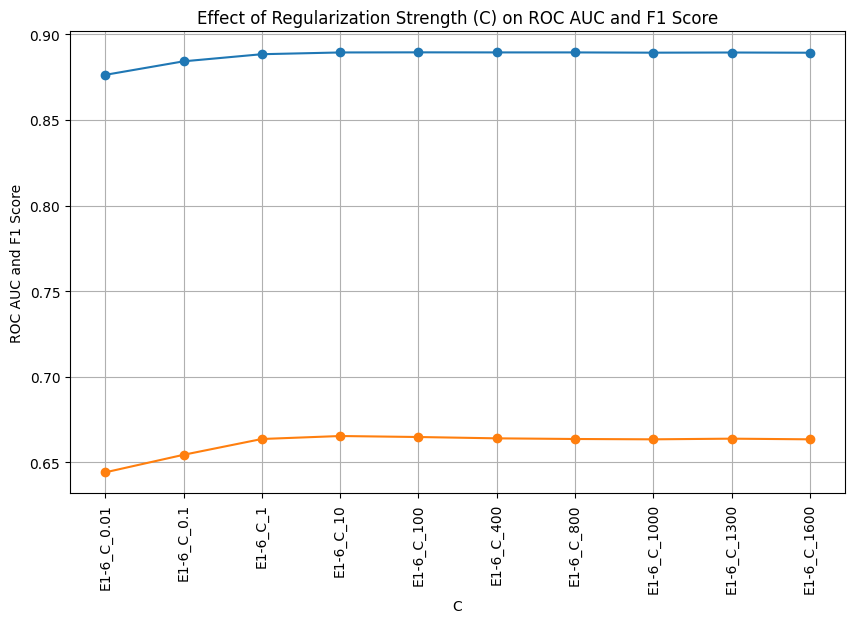

In [36]:
# plot C vs ROC AUC
plt.figure(figsize=(10, 6))
plt.plot(df_c_results['experiment'], df_c_results['roc_auc'], marker='o')
plt.plot(df_c_results['experiment'], df_c_results['f1_score'], marker='o')
plt.xlabel('C')
plt.ylabel('ROC AUC and F1 Score')
plt.xticks(rotation=90)
plt.title('Effect of Regularization Strength (C) on ROC AUC and F1 Score')
plt.grid(True)
plt.show()

Choose C between 100 and 800, precision, recall, f1_score, roc auc, not change significant.

The choice is 400 or 800. I prefer use 400 because it's more generic than 800. 

Let's check with kfold to confirm 400 is sweet spot.

### Cross validation

In [37]:
# select multiple C and do cross validation with it
arr_c_cross = [100, 300, 400, 500, 800]

cv_results = []

X_full_train_ext = pd.concat([X_train_ext, X_val_ext], ignore_index=True)
y_full_train_ext = np.concatenate([y_train_ext, y_val_ext])

for c in arr_c_cross:
    # Preprocess and model via helpers
    preprocessor = build_preprocessor(
        categorical_cols=categorical_cols_ext,
        numerical_cols=numerical_cols_ext,
        use_log1p=True,
        use_scaler=True
    )

    model = build_lr_pipeline(
        preprocessor=preprocessor,
        class_weight='balanced',
        C= c
    )

    #m = model.fit(X_train_ext, y_train_ext)

    #r = evaluate_model(pipe, X_full_train_ext, y_full_train_ext, 
    #                   experiment=f"E6_C_{c}", model_name="Logistic Regression", printOut=False)
    
    # K-Fold (Stratified to maintain class balance)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    # Evaluate multiple metrics
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv = cross_validate(model, X_full_train_ext, y_full_train_ext, cv=kf, scoring=scoring, n_jobs=-1)
    cv['C'] = c
    #print(cv)
    # calculate mean and std for each metric and add to cv_results
    #for metric in scoring:
    #    cv[f'{metric}_mean'] = np.mean(cv[f'test_{metric}'])
    #    cv[f'{metric}_std'] = np.std(cv[f'test_{metric}'])
        
    cv_mean = {
        'C': c,
        'accuracy_mean': np.mean(cv['test_accuracy']),
        'accuracy_std': np.std(cv['test_accuracy']),
        'precision_mean': np.mean(cv['test_precision']),
        'precision_std': np.std(cv['test_precision']),
        'recall_mean': np.mean(cv['test_recall']),
        'recall_std': np.std(cv['test_recall']),
        'f1_mean': np.mean(cv['test_f1']),
        'f1_std': np.std(cv['test_f1']),
        'roc_auc_mean': np.mean(cv['test_roc_auc']),
        'roc_auc_std': np.std(cv['test_roc_auc']),
    }
    cv_results.append(cv_mean)

    #break


In [38]:
df_cd_results = pd.DataFrame(cv_results)

In [39]:
df_cd_results

,C,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
0,100,0.821516,0.003721,0.564454,0.006805,0.797226,0.014653,0.660864,0.006724,0.888311,0.005066
1,300,0.821593,0.003715,0.564548,0.006818,0.797753,0.015266,0.661104,0.006833,0.888294,0.005066
2,400,0.821900,0.003298,0.565029,0.006217,0.798632,0.014061,0.661741,0.005811,0.888343,0.005142
3,500,0.821555,0.003505,0.564463,0.006687,0.798105,0.013427,0.661169,0.005651,0.888274,0.005115
4,800,0.822053,0.003186,0.565291,0.006032,0.798808,0.013767,0.661984,0.005615,0.888316,0.005161


In [40]:
df_cd_results[['C','f1_mean', 'f1_std']]

,C,f1_mean,f1_std
0,100,0.660864,0.006724
1,300,0.661104,0.006833
2,400,0.661741,0.005811
3,500,0.661169,0.005651
4,800,0.661984,0.005615


In [41]:
df_cd_results[['C','roc_auc_mean', 'roc_auc_std']]

,C,roc_auc_mean,roc_auc_std
0,100,0.888311,0.005066
1,300,0.888294,0.005066
2,400,0.888343,0.005142
3,500,0.888274,0.005115
4,800,0.888316,0.005161


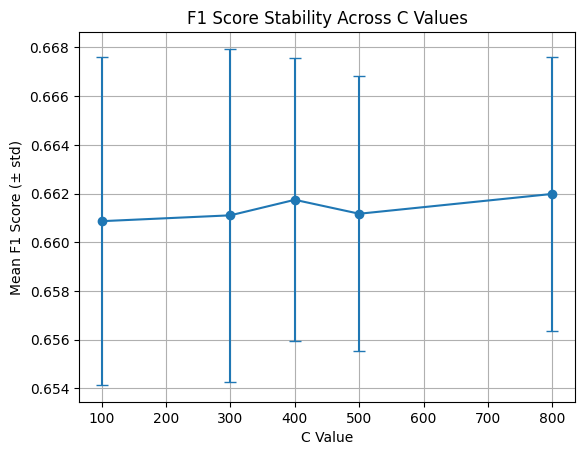

In [42]:
plt.errorbar(df_cd_results['C'], df_cd_results['f1_mean'], yerr=df_cd_results['f1_std'], fmt='-o', capsize=4)
plt.xlabel("C Value")
plt.ylabel("Mean F1 Score (± std)")
plt.title("F1 Score Stability Across C Values")
plt.grid(True)
plt.show()


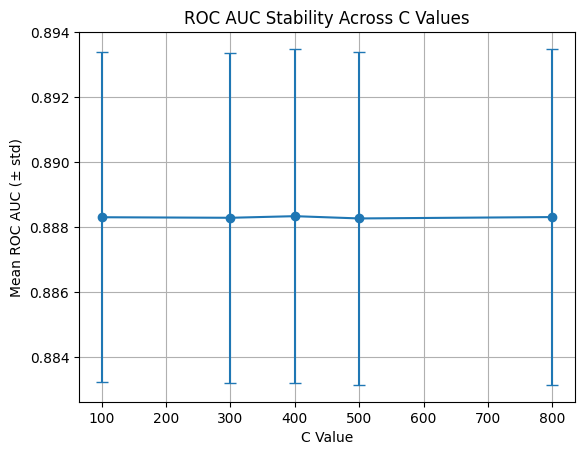

In [43]:
plt.errorbar(df_cd_results['C'], df_cd_results['roc_auc_mean'], yerr=df_cd_results['roc_auc_std'], fmt='-o', capsize=4)
plt.xlabel("C Value")
plt.ylabel("Mean ROC AUC (± std)")
plt.title("ROC AUC Stability Across C Values")
plt.grid(True)
plt.show()


Base on cross validation accross multiple C value, selected C=400 is a balance.

Train model for experiment E1-6 with C=400

In [44]:
C = 400
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols_ext,
    numerical_cols=numerical_cols_ext,
    use_log1p=True,
    use_scaler=True
)

model = build_lr_pipeline(
    preprocessor=preprocessor,
    class_weight='balanced',
    C=C
)

e16_model = model.fit(X_train_ext, y_train_ext)

r = evaluate_model(e16_model, X_val_ext, y_val_ext, 
                   experiment=f"E1-6_C_{C}", model_name="Logistic Regression", printOut=False)
arr_experiment_results.append(r)

## Summary Experiment Results

In [45]:
# convert arr_experiment_results to DataFrame for better visualization
df_results = pd.DataFrame(arr_experiment_results)
df_results

,model,experiment,accuracy,precision,recall,f1_score,roc_auc,fpr,tpr,confusion_matrix,threshold
0,Logistic Regression,E1-1,0.808625,0.800000,0.163265,0.271186,0.766548,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.002814919071076...","[[5037, 58], [1189, 232]]",0.5
1,Logistic Regression,E1-2,0.743094,0.449054,0.784659,0.571209,0.832630,"[0.0, 0.0, 0.0, 0.0003925417075564279, 0.00039...","[0.0, 0.0007037297677691766, 0.027445460942997...","[[3727, 1368], [306, 1115]]",0.5
2,Logistic Regression,E1-3,0.812615,0.548828,0.790992,0.648025,0.875232,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.026741731175228...","[[4171, 924], [297, 1124]]",0.5
3,Logistic Regression,E1-4,0.814764,0.552918,0.786770,0.649434,0.875450,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.008444757213230...","[[4191, 904], [303, 1118]]",0.5
4,Logistic Regression,E1-5,0.822284,0.565067,0.803659,0.663568,0.888446,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.004222378606615...","[[4216, 879], [279, 1142]]",0.5
5,Logistic Regression,E1-6_C_400,0.822591,0.565627,0.803659,0.663953,0.889496,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[4218, 877], [279, 1142]]",0.5


In [46]:
print(df_results[['experiment', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].round(3))

   experiment  accuracy  precision  recall  f1_score  roc_auc
0        E1-1     0.809      0.800   0.163     0.271    0.767
1        E1-2     0.743      0.449   0.785     0.571    0.833
2        E1-3     0.813      0.549   0.791     0.648    0.875
3        E1-4     0.815      0.553   0.787     0.649    0.875
4        E1-5     0.822      0.565   0.804     0.664    0.888
5  E1-6_C_400     0.823      0.566   0.804     0.664    0.889


### Logistic Regression Coefficient

In [47]:
coef = e16_model.named_steps['clf'].coef_[0]

coef

array([ 3.29859543e-01,  4.50843129e-01, -1.50077839e+00,  1.01207775e+00,
        4.61796989e-01, -2.88716683e-01,  7.52661007e-01,  4.87066466e-02,
        2.12767419e-02, -7.03722670e-01, -2.30491346e+00, -2.07977611e+00,
       -1.78430556e+00,  3.09974206e-01,  6.24292113e-01,  1.02434909e+00,
        4.50238176e+00,  1.60573633e-01,  1.31428398e-01,  7.85110354e+00,
       -2.26772326e+01, -2.26347571e-01, -4.51650137e-01,  9.17556333e-01,
       -6.51910282e+00, -3.67824136e-01,  9.25382542e+00,  2.25086334e+01,
        2.58562285e-01,  2.01632076e-01, -1.78951793e+00])

In [48]:
ohe_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols_ext)
num_features = numerical_cols_ext
feature_names = np.concatenate([ohe_features, num_features])

print(ohe_features)
print(num_features)
print(len(feature_names))

['person_home_ownership_mortgage' 'person_home_ownership_other'
 'person_home_ownership_own' 'person_home_ownership_rent'
 'loan_intent_debtconsolidation' 'loan_intent_education'
 'loan_intent_homeimprovement' 'loan_intent_medical'
 'loan_intent_personal' 'loan_intent_venture' 'loan_grade_a'
 'loan_grade_b' 'loan_grade_c' 'loan_grade_d' 'loan_grade_e'
 'loan_grade_f' 'loan_grade_g' 'cb_person_default_on_file_n'
 'cb_person_default_on_file_y']
['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_to_income', 'income_per_age', 'credit_age_ratio', 'emp_stability', 'risk_index']
31


In [49]:
X_train_ext.shape

(19548, 16)

In [50]:
categorical_cols_ext

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [51]:
numerical_cols_ext

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'loan_to_income',
 'income_per_age',
 'credit_age_ratio',
 'emp_stability',
 'risk_index']

In [52]:
preprocessor.named_transformers_['cat'].get_feature_names_out()

array(['person_home_ownership_mortgage', 'person_home_ownership_other',
       'person_home_ownership_own', 'person_home_ownership_rent',
       'loan_intent_debtconsolidation', 'loan_intent_education',
       'loan_intent_homeimprovement', 'loan_intent_medical',
       'loan_intent_personal', 'loan_intent_venture', 'loan_grade_a',
       'loan_grade_b', 'loan_grade_c', 'loan_grade_d', 'loan_grade_e',
       'loan_grade_f', 'loan_grade_g', 'cb_person_default_on_file_n',
       'cb_person_default_on_file_y'], dtype=object)

In [53]:
len(coef)

31

In [54]:
# get coef and feature names
lr = e16_model.named_steps['clf']

# get ColumnTransformer
preprocessor = e16_model.named_steps['preprocessor']

feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    if name == 'remainder':
        continue
    
    if name == 'cat':
        # OneHotEncoder case
        names = transformer.get_feature_names_out(cols)
    
    elif name == 'num':
        # numeric pipeline case (log1p + scaler)
        if hasattr(transformer, 'named_steps'):
            last_step = list(transformer.named_steps.values())[-1]
            if hasattr(last_step, 'get_feature_names_out'):
                names = last_step.get_feature_names_out(cols)
            else:
                names = cols
        else:
            names = cols
    
    else:
        names = cols  
    feature_names.extend(names)

# get coefficients
coefs = lr.coef_.ravel()

# combine into dataframe
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
}).sort_values(by='coefficient', key=np.abs, ascending=False)




In [55]:
coef_df.sort_values(by='coefficient', ascending=False)

,feature,coefficient
27,income_per_age,22.508633
26,loan_to_income,9.253825
19,person_age,7.851104
16,loan_grade_g,4.502382
15,loan_grade_f,1.024349
3,person_home_ownership_rent,1.012078
23,loan_int_rate,0.917556
6,loan_intent_homeimprovement,0.752661
14,loan_grade_e,0.624292
4,loan_intent_debtconsolidation,0.461797


## Find Best Threshold

In [56]:
thresholds = np.arange(0, 1.01, 0.01)

arr_threshold_results = []
for t in thresholds:
    r = evaluate_model(e16_model, X_val_ext, y_val_ext, threshold=t,
                    experiment=f"E1-7_C_{C}", model_name="Logistic Regression", printOut=False)
    arr_threshold_results.append(r)
    
#best_threshold = thresholds[np.argmax(arr_threshold_results)]

#print('Best threshold:', best_threshold)
#print('Best f1 score:', max(f1_scores))

/tmp/ipykernel_37417/3799421616.py:7: RuntimeWarning: invalid value encountered in scalar divide
  precision = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])


In [57]:
arr_threshold_results

[{'model': 'Logistic Regression',
  'experiment': 'E1-7_C_400',
  'accuracy': 0.21807857581338244,
  'precision': 0.21807857581338244,
  'recall': 1.0,
  'f1_score': 0.3580697996724203,
  'roc_auc': 0.8894959181601645,
  'fpr': array([0.        , 0.        , 0.        , ..., 0.98763494, 0.98763494,
         1.        ]),
  'tpr': array([0.00000000e+00, 7.03729768e-04, 7.03729768e-03, ...,
         9.99296270e-01, 1.00000000e+00, 1.00000000e+00]),
  'confusion_matrix': array([[   0, 5095],
         [   0, 1421]]),
  'threshold': 0.0},
 {'model': 'Logistic Regression',
  'experiment': 'E1-7_C_400',
  'accuracy': 0.23050951503990177,
  'precision': 0.22064997667547814,
  'recall': 0.9985925404644617,
  'f1_score': 0.36143657666836476,
  'roc_auc': 0.8894959181601645,
  'fpr': array([0.        , 0.        , 0.        , ..., 0.98763494, 0.98763494,
         1.        ]),
  'tpr': array([0.00000000e+00, 7.03729768e-04, 7.03729768e-03, ...,
         9.99296270e-01, 1.00000000e+00, 1.00000000e

In [58]:
df_th_results = pd.DataFrame(arr_threshold_results)
df_th_results

,model,experiment,accuracy,precision,recall,f1_score,roc_auc,fpr,tpr,confusion_matrix,threshold
0,Logistic Regression,E1-7_C_400,0.218079,0.218079,1.000000,0.358070,0.889496,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[0, 5095], [0, 1421]]",0.00
1,Logistic Regression,E1-7_C_400,0.230510,0.220650,0.998593,0.361437,0.889496,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[83, 5012], [2, 1419]]",0.01
2,Logistic Regression,E1-7_C_400,0.253376,0.225883,0.998593,0.368428,0.889496,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[232, 4863], [2, 1419]]",0.02
3,Logistic Regression,E1-7_C_400,0.278392,0.231813,0.997889,0.376227,0.889496,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[396, 4699], [3, 1418]]",0.03
4,Logistic Regression,E1-7_C_400,0.308318,0.239446,0.997889,0.386218,0.889496,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[591, 4504], [3, 1418]]",0.04
...,...,...,...,...,...,...,...,...,...,...,...
96,Logistic Regression,E1-7_C_400,0.819214,0.929329,0.185081,0.308685,0.889496,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[5075, 20], [1158, 263]]",0.96
97,Logistic Regression,E1-7_C_400,0.811387,0.952830,0.142153,0.247397,0.889496,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[5085, 10], [1219, 202]]",0.97
98,Logistic Regression,E1-7_C_400,0.803867,0.967320,0.104152,0.188056,0.889496,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[5090, 5], [1273, 148]]",0.98
99,Logistic Regression,E1-7_C_400,0.795273,0.978022,0.062632,0.117725,0.889496,"[0.0, 0.0, 0.0, 0.00019627085377821394, 0.0001...","[0.0, 0.0007037297677691766, 0.007037297677691...","[[5093, 2], [1332, 89]]",0.99


In [59]:
best_threshold = thresholds[np.argmax(df_th_results['f1_score'])]

print('Best threshold:', best_threshold)
print('Best f1 score:', max(df_th_results['f1_score']))
print('Best precision:', df_th_results.loc[df_th_results['f1_score'].idxmax()]['precision'] )
print('Best recall:', df_th_results.loc[df_th_results['f1_score'].idxmax()]['recall'] )
print("Confusion Matrix:\n", df_th_results.loc[df_th_results['f1_score'].idxmax()]['confusion_matrix'] )

Best threshold: 0.68
Best f1 score: 0.7083037615330021
Best precision: 0.7143879742304939
Best recall: 0.7023223082336383
Confusion Matrix:
 [[4696  399]
 [ 423  998]]


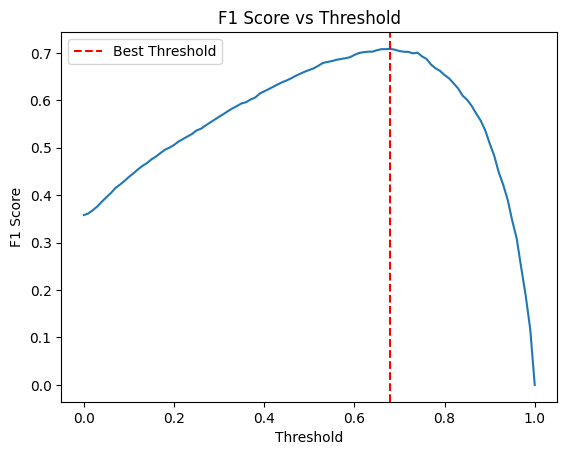

In [60]:
# plot f1 scores vs thresholds
plt.plot(df_th_results['threshold'], df_th_results['f1_score'])
# draw vertical line at best threshold
plt.axvline(x=best_threshold, color='r', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.show()

In [61]:
# calculate precision and recall crossing
array_precision = df_th_results['precision'].values
array_recall = df_th_results['recall'].values

# threshold with precision cross recall
cross_threshold = 0.0
for i in range(len(thresholds)):
    if array_precision[i] >= array_recall[i]:
        cross_threshold = thresholds[i]
        print(f'Threshold Cross: {cross_threshold:.2f}, Precision: {array_precision[i]:.3f}, Recall: {array_recall[i]:.3f}')
        break


Threshold Cross: 0.68, Precision: 0.714, Recall: 0.702


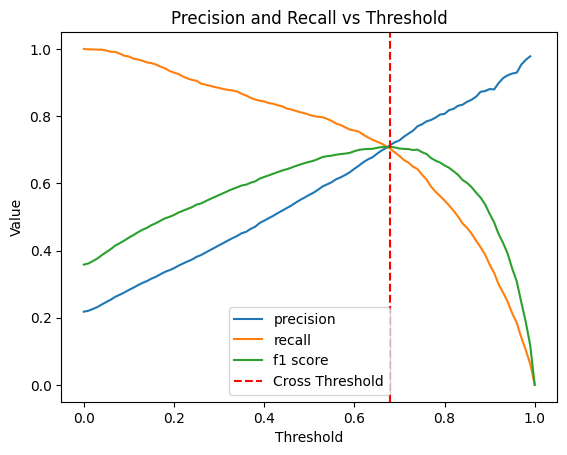

In [62]:
plt.plot(df_th_results['threshold'], df_th_results['precision'], label='precision')
plt.plot(df_th_results['threshold'], df_th_results['recall'], label='recall')  
plt.plot(df_th_results['threshold'], df_th_results['f1_score'], label='f1 score')
plt.axvline(x=cross_threshold, color='r', linestyle='--', label='Cross Threshold')
plt.title('Precision and Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()
plt.show()

## Final Model Training with dataset (train+val)

The performance reported below is evaluated only on the test set, which was never used during model training or tuning.

Final model train using parameter C=400 and threshold 0.71 and 0.68.

In [63]:
# combine train + val

X_full_train_ext = pd.concat([X_train_ext, X_val_ext], ignore_index=True)
y_full_train_ext = np.concatenate([y_train_ext, y_val_ext])

preprocessor = build_preprocessor(
    categorical_cols=categorical_cols_ext,
    numerical_cols=numerical_cols_ext,
    use_log1p=True,
    use_scaler=True
)

model = build_lr_pipeline(
    preprocessor=preprocessor,
    class_weight='balanced',
    C=400
)

final_model = model.fit(X_full_train_ext, y_full_train_ext)


# do with test dataset
r_th071 = evaluate_model(final_model, X_test_ext, y_test_ext, threshold=0.71,
                    experiment=f"E1-final", model_name="Logistic Regression", printOut=False)

r_th068 = evaluate_model(final_model, X_test_ext, y_test_ext, threshold=0.68,
                    experiment=f"E1-final", model_name="Logistic Regression", printOut=False)

#print(r_th071)
#print(r_th068)

In [64]:
print("threshold 0.71")
print('f1 score:', r_th071['f1_score'])
print('precision:', r_th071['precision'])
print('recall:', r_th071['recall'])
print("Confusion Matrix:\n", r_th071['confusion_matrix'])

print()

print("threshold 0.68")
print('f1 score:', r_th068['f1_score'])
print('precision:', r_th068['precision'])
print('recall:', r_th068['recall'])
print("Confusion Matrix:\n", r_th068['confusion_matrix'])

threshold 0.71
f1 score: 0.6943423952975754
precision: 0.7269230769230769
recall: 0.6645569620253164
Confusion Matrix:
 [[4740  355]
 [ 477  945]]

threshold 0.68
f1 score: 0.6929078014184397
precision: 0.6988555078683834
recall: 0.6870604781997187
Confusion Matrix:
 [[4674  421]
 [ 445  977]]


In [65]:
# combine r_th071 and r_th068 into a single DataFrame
df_final_results = pd.DataFrame([r_th071, r_th068])

df_final_results[['experiment', 'threshold', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]

,experiment,threshold,accuracy,precision,recall,f1_score,roc_auc
0,E1-final,0.71,0.872334,0.726923,0.664557,0.694342,0.889232
1,E1-final,0.68,0.867117,0.698856,0.687060,0.692908,0.889232


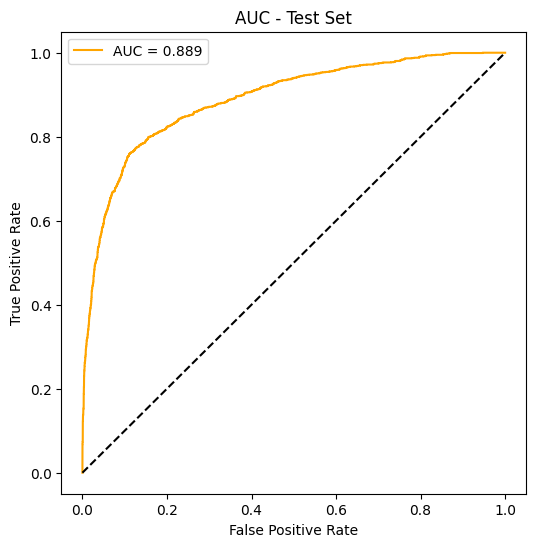

In [66]:
#fpr071, tpr071 = df_final_results.iloc[0]['fpr'], df_final_results.iloc[0]['tpr']
fpr068, tpr068 = df_final_results.iloc[1]['fpr'], df_final_results.iloc[1]['tpr']
#roc_auc071 = auc(fpr071, tpr071)
roc_auc068 = auc(fpr068, tpr068)

plt.figure(figsize=(6,6))
#plt.plot(fpr071, tpr071, label=f'AUC = {roc_auc071:.3f}', color='blue')
plt.plot(fpr068, tpr068, label=f'AUC = {roc_auc068:.3f}', color='orange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC - Test Set')
plt.legend()
plt.show()


Threshold: 0.71
- f1 score: 0.6948218876239441
- precision: 0.7271329746348962
- recall: 0.6652601969057665

Threshold: 0.68
- f1 score: 0.6917080085046067
- precision: 0.6971428571428572
- recall: 0.6863572433192686

From this result comparing threshold 0.71 & 0.68:
- F1 score is higher with threshold 0.71
- With threshold 0.71, precision high and recall a little lower, it means model ability to capture loan approve is less than using threshold 0.68. 
- Choose 0.71 if precision is priority (correctness of approvals is priority, to avoiding approving risky loans)
- Choose 0.68 if ability to capture the loan approve, is priority. To capture more potential good loans, even if a few risky ones slip in.
